In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

# define threshold of popular support for major parties:
MAJ_PARTY_THRESH=0.05

In [2]:
WORKDIR = os.getcwd()
Vote_data_path = "./source_data/DL_BE_AB2016_V2_formatted.txt"
Data_RAW = pd.read_csv( Vote_data_path, sep="\t", header=0 )
n_ridings     = Data_RAW.shape[0]
n_parties_all = Data_RAW.shape[1]-17

#Data_RAW.head
print( Data_RAW.shape )
print( n_ridings )
print( n_parties_all )

(2432, 43)
2432
26


In [3]:
# cross-check that the sum of all party votes adds up to the "valid" column
assert max(abs([sum( Data_RAW.values[n,17:]) for n in range(n_ridings) ] -  Data_RAW.values[:,16])) == 0
# first index corresponding to a party's vote tally is 17, continues in decreasing order of total votes.
party_names_all = Data_RAW.columns[17:]

print(party_names_all)

Index(['SPD', 'CDU', 'GRÜNE', 'LINKE', 'PIRATEN', 'NPD', 'FDP',
       'Tierschutzpartei', 'pro.Deutschland', 'DiePARTEI', 'BIG', 'DKP', 'ödp',
       'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz', 'AfD',
       'DIE.EINHEIT', 'DIE.VIOLETTEN', 'Graue.Panther', 'MENSCHLICHE.WELT',
       'MIETERPARTEI', 'Gesundheits.forschung'],
      dtype='object')


In [4]:
# separate ridings into "Urnen" (ballot box) Bezirks, and "Brief" (mail-in ballot) bezirks
Data_Urn   = Data_RAW.loc[ Data_RAW["Wahlbezirksart"] == "Urnenwahlbezirk" ]
Data_Brief = Data_RAW.loc[ Data_RAW["Wahlbezirksart"] == "Briefwahlbezirk" ]
# Old way of doing it: Data_Urn   = Data_RAW.set_index("Wahlbezirksart").loc["Urnenwahlbezirk"]

n_ridings_urn = Data_Urn.shape[0]
print( n_ridings_urn )

# ====== we will work primarily with the "Urn" data (since there are many more of them)
# we'll come back to the Brief data later to check for robustness.

1779


In [5]:
# Collect all votes 
votes_RAW= Data_RAW.values[:,17:]
print(votes_RAW.shape)

# Collect vote totals per party
party_votes = [ sum( votes_RAW[:,n]) for n in range(n_parties_all) ]

# And sum them up for the total num votes over all parties
Total_votes_allparties = sum(party_votes)
print( Total_votes_allparties )

(2432, 26)
1635169


In [6]:
# Now determine the fraction of all votes allocated to each party
party_voteshare = [ party_votes[n]/Total_votes_allparties for n in range(n_parties_all) ]

# And define the "major" parties as those above 5% total support
major_parties = [ party_names_all[p] for p in range(n_parties_all) if party_voteshare[p]> MAJ_PARTY_THRESH ]
minor_parties = list( party_names_all.difference( major_parties ) )

n_parties_major = len(major_parties)
print( "Major parties : "); print( major_parties )
print( "Minor parties : "); print( minor_parties )

Major parties : 
['SPD', 'CDU', 'GRÜNE', 'LINKE', 'FDP', 'AfD']
Minor parties : 
['ALFA', 'B', 'BIG', 'BüSo', 'DIE.EINHEIT', 'DIE.VIOLETTEN', 'DKP', 'DL', 'DiePARTEI', 'Gesundheits.forschung', 'Graue.Panther', 'MENSCHLICHE.WELT', 'MIETERPARTEI', 'NPD', 'PIRATEN', 'PSG', 'Tierschutzallianz', 'Tierschutzpartei', 'pro.Deutschland', 'ödp']


In [7]:
 # ==========================================================================================================

In [8]:
# Select just the major parties:
Data_urn_major         = Data_Urn[major_parties]
Data_urn_major.index   = range( Data_urn_major.shape[0] )


# === Collect the invalid + minor party votes, and bin them all into a separate column "other"  
Other=pd.DataFrame( { "Other": [sum((Data_Urn[minor_parties+["invalid"]]).values[n,:]) 
                                         for n in range(Data_Urn.shape[0]) ] } )

# Create a df with just these "parties"
Data_urn_filtered = pd.merge( Data_urn_major, 
                              Other, 
                              left_index=True, 
                              right_index=True )

# Normalize vote-shares
Data_urn_normed  = Data_urn_filtered.copy()
for i in range( Data_urn_normed.shape[0] ):
    Data_urn_normed.loc[i] = Data_urn_normed.loc[i] / sum( Data_urn_normed.loc[i] )

In [9]:
# isolate an O-W list
Data_Urn_OW_list = Data_Urn["OstWest"]
Data_Urn_OW_list.index  = range( len(Data_Urn_OW_list)  )
Data_Urn_OW_list

0       W
1       O
2       O
3       O
4       O
       ..
1774    W
1775    W
1776    W
1777    W
1778    W
Name: OstWest, Length: 1779, dtype: object

In [10]:
# Get the mean positions of each of the groups
meanpoint_Ost  = np.mean( Data_urn_normed.loc[ Data_Urn_OW_list =="O"  ] )
meanpoint_West = np.mean( Data_urn_normed.loc[ Data_Urn_OW_list =="W"  ] )

# And define a vector pointint in the direction from one to the other.
OW_vec = (meanpoint_Ost - meanpoint_West)/np.linalg.norm( meanpoint_Ost - meanpoint_West ) 

print (np.linalg.norm( OW_vec ))

1.0


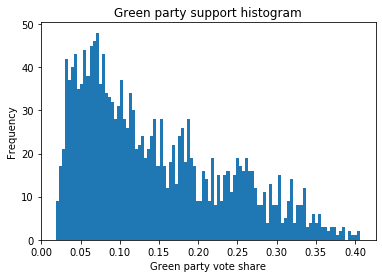

In [11]:
dummy = plt.hist( Data_urn_normed["GRÜNE"], 
                  bins = 100)
dummy = plt.xlabel("Green party vote share")
dummy = plt.ylabel("Frequency")
dummy = plt.title("Green party support histogram")

In [12]:
Data_urn_nparr     = Data_urn_normed.copy().values
DPC = Data_urn_nparr.copy()

pca  = PCA()
DPC = pca.fit_transform(DPC)
# confirm that the norm-distances between points is invariant
def normdiff( Dat, i, j):
    return math.sqrt( sum( (Dat[i,:] - Dat[j,:])**2 ) )
# confirm that absdiffs are unchanged
# print( normdiff( Data_urn_nparr, 52 , 21) )
# print( normdiff( DPC, 52 , 21) )

In [13]:
# define a list of integers for who won the region.
Winner_list = [ np.argmax( Data_urn_normed.iloc[n].values) for n in  range(n_ridings_urn) ]
len(Winner_list)

# Data_Urn["OstWest"].values
OW_ccode       = [ "blue"  if x=="W" else "red"   for x in Data_Urn["OstWest"].values ]
Go20pc_ccode   = [ "green" if x>0.2  else "black" for x in Data_urn_normed["GRÜNE"]   ]
Gwinner_ccode  = [ "green" if x==2   else "black" for x in Winner_list ]

Gwinner_OW_ccode  = [ "green" if Winner_list[x]==2 
                       else "blue" if Data_Urn["OstWest"].values[x]=="W" 
                       else "red" 
                       for x in range(len(Winner_list)) ]

Go20pc_OW_ccode  = [ "green" if Data_urn_normed["GRÜNE"][x] >0.2 
                       else "blue" if Data_Urn["OstWest"].values[x]=="W" 
                       else "red" 
                       for x in range(len(Winner_list)) ]

# both_ccode =  [ "green" if Data_urn_normed["GRÜNE"][x]>0.2  else OW_ccode[x] for x in len(Data_urn_normed["GRÜNE"]) ]

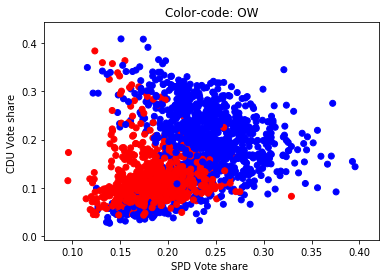

In [19]:
plt.scatter( Data_urn_nparr[:, 0], 
             Data_urn_nparr[:, 1],
             c= OW_ccode );
dummy = plt.xlabel( major_parties[0] + " Vote share " )
dummy = plt.ylabel( major_parties[1] + " Vote share " )
dummy = plt.title("Color-code: OW")


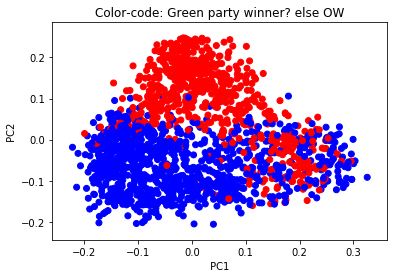

In [138]:
plt.scatter( DPC[:, 0], 
             DPC[:, 1],
             c = OW_ccode  );
dummy = plt.xlabel( " PC1 " )
dummy = plt.ylabel( " PC2 " )
dummy = plt.title("Color-code: Green party winner? else OW")

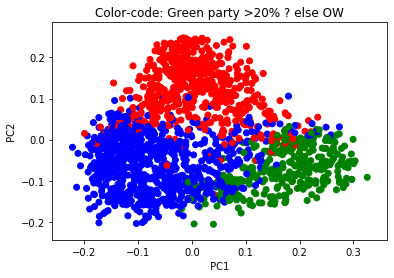

In [140]:
plt.scatter( DPC[:, 0], 
             DPC[:, 1],
             c = Gwinner_OW_ccode );
dummy = plt.xlabel( " PC1 " )
dummy = plt.ylabel( " PC2 " )
dummy = plt.title("Color-code: Green party >20% ? else OW")

In [23]:
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=2)
kmeans_3 = KMeans(n_clusters=3)

kmeans_2.fit(Data_urn_nparr)
kmeans_3.fit(Data_urn_nparr)

kmeans_2.predict(Data_urn_nparr)

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [90]:
def calc_percW(OWarray, kMeansarray, n):
    temp  = OWarray[ kMeansarray == n ]
    tempW = temp[temp=="W"]
    return (len(tempW)/len(temp))

def cleanclusters( k, Dat, OWarray ):
    # automate clustering, but ensure a standardized convention so that the "west" block is always 0, East 1.
    km = KMeans( n_clusters=k )
    km.fit(Dat)
    clusters = km.predict( Dat )
    # this is now an array of cluster value assignments 0..k, but the values are arbitrary and randomly assigned.
    # Now put them in order of "W" percentage so that they can be referred to consistently.
    
    percW     = [ calc_percW(OWarray, clusters,n) for n in set(clusters) ]   
    arb_order = sorted( [ x[::-1] for x in enumerate(percW) ] )[::-1]
    # This is a set of tuples, the latter value of which indicates the arbitrary label, which we now reassign
    
    # Now re-order the entries in the _copy set
    clusters_ordered = clusters.copy()

    for i in range(len(percW)):
        clusters_ordered [ clusters == arb_order[i][1] ] = i
       
    return clusters_ordered 

# ------------------------------------------------------
def iprod( u, v):
    return (sum(u*v))

# ------------------------------------------------------
def norm( u ):
    return math.sqrt(sum(u*u))

# ------------------------------------------------------
def dist( u, v ):
    return math.sqrt(sum( (u-v)**2 )) 

# ------------------------------------------------------
def proj_uv( u, v ):
    #---- PROJECTS v ONTO u 

    assert ( len(u.shape) == 1 and len(v.shape) ==1 )
    assert ( len(u) == len(v) )
            
    result =  (iprod(u,v) / iprod(u,u)) *u
  
    return(result)

# ------------------------------------------------------
def gen_orthnorm_rot_mat( v ):
    assert v.shape[0] > 1 and len( v.shape )==1
    N= v.shape[0]
    
    result      = np.zeros([N,N])
    result[:,0] = v/(norm(v))
    
    # now build the rest of the vectors 
    for i in range(1,N):
        temp_new    = np.ones(N)
        temp_new[i] = 2
        
        # ensure that they each orthogonal to all previous vectors:
        for j in range(i):
            temp_new = temp_new - proj_uv(result[:,j], temp_new)
            
        # And normalize them before assigning them to the output    
        result[:,i] = temp_new/norm( temp_new )
        
    return(result)

# ========================================================
def rotate_data_along_vec_PCs( Dat, vec, TOL=0.0001 ): 
    # Rotate data into, first, a preferred direction given by "vec", and then thereafter by PCs
    assert len(vec.shape) == 1
    assert Dat.shape[1]   == vec.shape [0]
  
    Ndim    = Dat.shape[1]
    Npoints = Dat.shape[0]
    
    vec_normed = (vec/norm(vec))
    Dat_output = np.zeros([Npoints, Ndim])
    
    # Generate a rotation matrix where the first (0) column rotates into the direction of "vec"
    # The columns after that are arbitary, so long as they all form an orthnormal complete basis
    RM0 = gen_orthnorm_rot_mat( vec_normed )
    
    # Now make first rotation into this basis
    Dat_rot0   = np.transpose( np.matmul( np.transpose( RM0 ), np.transpose(Dat) ) )
       
    # And keep only the first column
    Dat_output[:,0] = Dat_rot0[:,0]
                                 
    # The remainder will then undergo SVD:    
    Dat_rot0_subset = Dat_rot0[:,1:].copy()
    U, S, V  = np.linalg.svd( Dat_rot0_subset, 
                             full_matrices=False)
   
    # Rotate the remaining N-1 vecs along their respective PCs
    Dat_rot1 = ( V.T @ Dat_rot0_subset.T ).T
    Dat_output[:,1:] =  Dat_rot1
    
#    return( Dat_rot0_subset, Dat_rot1 )
    # And assign them to the remaining Dof of the output:
#    Dat_output[:,1:] = Dat_rot1
#
#     # These commented lines are sanity checks:
#     norms_0 = np.array( [ norm( Dat[n,:])   for n in range(Npoints)] )
#     norms_1 = np.array( [ norm( Dat_output[n,:]) for n in range(Npoints)] )
#     return( norms_0, norms_1)
#     plt.scatter( norms_0, norms_1 ) 
#     distmat_in  = np.zeros([Npoints, Npoints])
#     distmat_out = np.zeros([Npoints, Npoints])    
#     for i in range(Npoints):
#        for j in range(Npoints):            
#           distmat_in[i,j]  = norm( Dat[i,:]        - Dat[j,:] )
#           distmat_out[i,j] = norm( Dat_output[i,:] - Dat_output[j,:] )
#     return ( abs( distmat_out - distmat_in) )
#     # DOWN TO HERE
 
    return ( Dat_output )

In [137]:
DU_rot=rotate_data_along_vec_PCs( Data_urn_nparr, OW_vec ) 
# Sanity check:
# m,n = np.random.randint(1,1778,2)
# print( dist(D2[m,:],  D2[n,:] ) - dist(Dat[m,:], Dat[n,:]) )

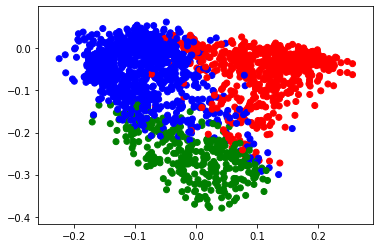

In [136]:
plt.scatter( DU_rot[:,0], DU_rot[:,2],
             c = Gwinner_OW_ccode   )